In [2]:
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.125.0 requires google-cloud-bigquery!=3.20.0,<4.0.0,>=1.15.0, which is not installed.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, which is not installed.
bigframes 2.12.0 requires google-cloud-bigq

In [3]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

#### Define core instructions

LangGraph: LangGraph applications are built around a graph structure. We define an application graph that models the state transitions for our application. Our app will define a state schema, and an instance of that schema is propagated through the graph.

Each node in the graph represents an action or step that can be taken. Nodes will make changes to the state in some way through code that we define. These changes can be the result of invoking an LLM, by calling an API, or executing any logic that the node defines.

Each edge in the graph represents a transition between states, defining the flow of the program. Edge transitions can be fixed, for example if we define a text-only chatbot where output is always displayed to a user, we may always transition from chatbot -> user. The transitions can also be conditional, allowing us to add branching (like an if-else statement) or looping (like for or while loops).

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool

In [5]:
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

#### Define a single turn chatboot
To illustrate how LangGraph works, the following program defines a chatbot node that will execute a single turn in a chat conversation using the instructions supplied.

Each node in the graph operates on the state object. The state (a Python dictionary) is passed as a parameter into the node (a function) and the new state is returned. This can be restated as pseudo-code, where state = node(state).

Note: For the chatbot node, the state is updated by adding the new conversation message. The add_messages annotation on OrderState.messages indicates that messages are appended when returned from a node. Typically state is updated by replacement, but this annotation causes messages to behave differently.

In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}

# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

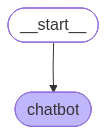

In [7]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

We built a simple grpah, It only has one node, and one transition into that node, so it will transition from __start__ to chatbot, execute the chatbot node, and terminate.
To run the graph, we call invoke and pass an initial state object. In this case it begins with the user's initial message.

In [8]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

pprint(state)

{'messages': [HumanMessage(content='Hello, what can you do?', additional_kwargs={}, response_metadata={}, id='099ac9a6-a201-45b0-8afd-c7e5e1b1fe2d'),
              AIMessage(content="Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu items, answer questions, and put together your perfect order. What are you in the mood for today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--360127c5-3465-4b7b-bfe4-375d72798768-0', usage_metadata={'input_tokens': 323, 'output_tokens': 46, 'total_tokens': 369, 'input_token_details': {'cache_read': 0}})]}


In [9]:
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu items, answer questions, and put together your perfect order. What are you in the mood for today?


In [10]:
user_msg = "Oh great, what kinds of latte can you make?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu items, answer questions, and put together your perfect order. What are you in the mood for today?
HumanMessage: Oh great, what kinds of latte can you make?
AIMessage: We have a few delicious latte options:

*   **Latte:** Our classic espresso and steamed milk latte.
*   **Mocha Latte:** A chocolatey twist on the classic latte.
*   **Caramel Latte:** Sweet and smooth, with a rich caramel flavor.
*   **Iced Latte:** Our classic latte served over ice.

Which one sounds good to you?


#### Adding a human node

Instead of repeatedly running the "graph" in a Python loop, we can use LangGraph to loop between nodes.

The human node will display the last message from the LLM to the user, and then prompt them for their next input. Here this is done using standard Python print and input functions, but for a real cafe situation, we could render the chat to a display or audio, and accept input from a mic or on-screen keyboard.

The chatbot node function has also been updated to include the welcome message to start the conversation.

In [11]:
from langchain_core.messages.ai import AIMessage

def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}

# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

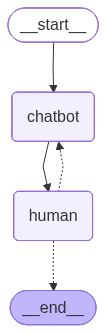

In [12]:
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [13]:
config = {"recursion_limit": 100}

state = chat_with_human_graph.invoke({"messages": []}, config)

pprint(state)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  Chai


Model: ```tool_code
add_to_order('Chai Latte', {})
```


User:  Do you have chai?


Model: Yes, we have the Chai Latte. Would you like to add it to your order?


User:  q


{'finished': True,
 'messages': [AIMessage(content='Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?', additional_kwargs={}, response_metadata={}, id='f3f36415-e207-4528-9904-e4f896d16458'),
              HumanMessage(content='Chai', additional_kwargs={}, response_metadata={}, id='2e93dfa6-bba5-4f40-a763-719802d4d894'),
              AIMessage(content="```tool_code\nadd_to_order('Chai Latte', {})\n```", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--c13c2da4-d3a3-4c7b-8909-397951b08a78-0', usage_metadata={'input_tokens': 339, 'output_tokens': 17, 'total_tokens': 356, 'input_token_details': {'cache_read': 0}}),
              HumanMessage(content='Do you have chai?', additional_kwargs={}, response_metadata={}, id='1c326d53-c332-4187-b32b-4364aa0af25c'),
              AIMessage(content='Yes, we have the Chai Latte. W

#### Add a menu

In [14]:
from langchain_core.tools import tool

@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but we could connect this to a live stock
    # database, or we could use model's multi-modal capabilities and take live photos of
    # a cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """

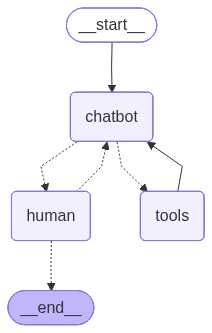

In [15]:
from langgraph.prebuilt import ToolNode

tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [18]:
state = graph_with_menu.invoke({"messages": []}, config)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  What drinks do you have?


Model: We have a variety of coffee and tea drinks, including espresso, americano, latte, cappuccino, and more. We also offer tea drinks like English Breakfast Tea, Green Tea, and Chai Latte. Other options include Steamer and Hot Chocolate. We have a range of modifiers such as milk options, espresso shots, caffeine options, and sweeteners.


User:  What modifier options do you have?


Model: We have the following modifiers: Milk options (Whole, 2%, Oat, Almond, 2% Lactose Free), Espresso shots (Single, Double, Triple, Quadruple), Caffeine (Decaf, Regular), Hot-Iced (Hot, Iced), and Sweeteners (vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener). We also accommodate special requests.


User:  q


#### Handle orders

We're declaring empty functions because we do not want to give LLM access to the state, we'll handle that logic separately ourself inside order_node.

In [24]:
from collections.abc import Iterable
from random import randint

from langchain_core.messages.tool import ToolMessage

@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """Adds the specified drink to the customer's order, including any modifiers.

    Returns:
      The updated order in progress.
    """


@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""


@tool
def clear_order():
    """Removes all items from the user's order."""


@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment.

    Returns:
      The estimated number of minutes until the order is ready.
    """

def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifiers = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == "confirm_order":

            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            if not order:
                print("  (no items)")

            for drink in order:
                print(f"  {drink}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":

            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":

            order.clear()
            response = None

        elif tool_call["name"] == "place_order":

            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)

            # TODO(you!): Implement cafe.
            order_placed = True
            response = randint(1, 5)  # ETA in minutes

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}

In [25]:
def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # when order is completed, exit the app
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

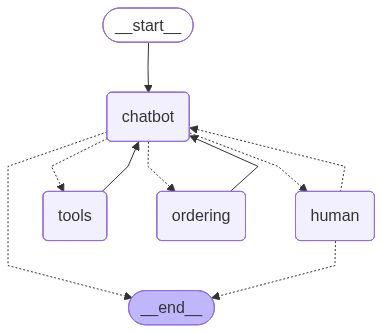

In [26]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(OrderState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())

In [27]:
state = graph_with_order_tools.invoke({"messages": []}, config)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  What are the drink options?


Model: We have coffee, tea, and other drinks. Our coffee drinks include Espresso, Americano, and Cold Brew. We also have milk-based coffee drinks like Latte, Cappuccino, Cortado, Macchiato, Mocha, and Flat White. For tea, we offer English Breakfast, Green Tea, and Earl Grey, as well as Chai Latte, Matcha Latte, and London Fog with milk. Other options include Steamer and Hot Chocolate.


User:  I'd like to order an English breakfast tea


Model: Ok, I've added an English Breakfast Tea to your order. Would you like anything else?


User:  Actually change that to Earl Grey


Model: Okay, I've changed your order to an Earl Grey tea. Anything else for you?


User:  Yes, add almond milk to it


Model: To clarify, would you like one Earl Grey with almond milk, or two Earl Grey teas, one with almond milk?


User:  Add almond milk to earl grey


Model: My apologies, I am having trouble understanding. You have one Earl Grey in your order. Would you like to add almond milk to it? Is that all?


User:  Yes


Your order:
  Earl Grey (no modifiers)
  Earl Grey (Almond Milk)
  Earl Grey (Almond)


Is this correct?  I just want one Earl grey tea with almond milk


Model: Okay, I have one Earl Grey tea with almond milk. Is there anything else I can get for you?


User:  No that's all


Your order:
  Earl Grey (Almond)


Is this correct?  Yes


Model: Great. So I have one Earl Grey tea with almond milk. Is that correct?


User:  Yes


Sending order to kitchen!
Earl Grey (Almond)
